In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge, HuberRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform

## Data processing

In [20]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

features = ['County', 'State', 'ZHVI_prev', 'ZHVI', 'Year', 'Month', 'UnemploymentRate', '#hospital',
       'hospital_rating', 'private_schools_count', 'public_schools_count',
       'CPI', 'Interest Rate', 'inc', 'inc_ineql', 'BD', 'highschool', 'migr', 'residt']
catFeatures = ['County', 'State']
numFeatures = list(set(features) - set(catFeatures))
#dropFeatures = list(set(train_data.columns) - set(features) - set(['ZHVI_next']))

train_data = train_data[train_data.Year >= 2012]
test_data = test_data[test_data.Year >= 2012]

dummies = pd.get_dummies(data[catFeatures])
data = data.drop(catFeatures, axis=1)
data = pd.concat([data, dummies], axis=1)

data = data.drop(dropFeatures, axis=1).sample(frac=1)
train_data = data[: int(.8*len(data))]
test_data = data[int(.8*len(data)): ]

train_data.to_csv('/Users/guannanliu/Documents/orie5741/Orie-4741-Project/data/train.csv', index = False, header=True)
test_data.to_csv('/Users/guannanliu/Documents/orie5741/Orie-4741-Project/data/test.csv', index = False, header=True)

train_data['ZHVI_increase'] = train_data.ZHVI - train_data.ZHVI_prev
test_data['ZHVI_increase'] = test_data.ZHVI - test_data.ZHVI_prev
numFeatures.append('ZHVI_increase')

train_data.ZHVI = np.log(train_data.ZHVI)
train_data.ZHVI_next = np.log(train_data.ZHVI_next)
train_data.ZHVI_prev = np.log(train_data.ZHVI_prev)

In [21]:
mean = train_data[numFeatures].std()
sd = train_data[numFeatures].std()

train_stand = (train_data[numFeatures] - mean) / sd
test_stand = (test_data[numFeatures] - mean) / sd

train_data_scale = train_data.drop(numFeatures, axis=1)
train_data_scale = pd.concat([train_stand, train_data_scale], axis=1)

test_data_scale = test_data.drop(numFeatures, axis=1)
test_data_scale = pd.concat([test_stand, test_data_scale], axis=1)

In [22]:
trainX = train_data_scale.drop('ZHVI_next', axis=1)
trainY = train_data_scale['ZHVI_next']

testX = test_data_scale.drop('ZHVI_next', axis=1)
testY = test_data_scale['ZHVI_next']

## Model

In [65]:
def MAE(y, pred):
    return np.mean( np.abs(y - pred) )

def print_coefs(results, df):
    print('Intercept:\t', results.intercept_)
    for i in range(len(df.columns[:-1])):
        print(df.columns[i], ':\t', results.coef_[i])

def trend_accuracy(test_df, pred):
    trend = np.sign(test_df.ZHVI_next - test_df.ZHVI)
    trend_pred = np.sign(pred - test_df.ZHVI)

    return np.mean(trend == trend_pred)

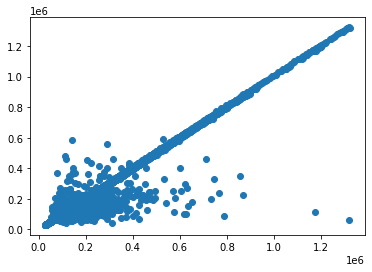

In [24]:
plt.scatter(train_data.ZHVI, train_data.ZHVI_next)

In [55]:
reg_sq = LinearRegression().fit(trainX, trainY)
pred_sq = reg_sq.predict(testX)

MAE(pred_sq, testY), trend_accuracy(test_data, pred_sq)

pred_sq_train = reg_sq.predict(trainX)
MAE(pred_sq_train, trainY), trend_accuracy(train_data, pred_sq_train)

(2312.3623521816016, 0.5656645042692917)

In [66]:
print_coefs(reg_sq, trainX)

Intercept:	 94293826246419.78
Year :	 2339.415535161039
CPI :	 -4399.159325819945
UnemploymentRate :	 -1483.121991565713
highschool :	 273.36943062976115
inc_ineql :	 125.35422413580454
private_schools_count :	 2017352338741108.5
BD :	 714.6119919585362
Month :	 -436.4690396979531
hospital_rating :	 -61.97112588900927
ZHVI_prev :	 -119387.84375
public_schools_count :	 -1899566019183019.0
#hospital :	 -1181.9375
ZHVI :	 226453.53125
migr :	 -159.640625
Interest Rate :	 1011.8125
inc :	 -919.390625
residt :	 2617.9375
County_Abbeville :	 -69061138191180.09
County_Ada :	 -1595555009989838.5
County_Adair :	 77035570943428.11
County_Adams :	 -169356580046038.38
County_Addison :	 35408539251832.016
County_Aiken :	 -94409910376390.4
County_Alachua :	 -182601328312782.53
County_Alameda :	 -383670936948604.1
County_Alamosa :	 -43529091528949.31
County_Albany :	 -99347264929703.75
County_Allegan :	 115516915419605.17
County_Allegany :	 -86947790559000.55
County_Allegheny :	 -1191738093525638.5
C

id = np.where(reg_sq.feature_names_in_ == 'ZHVI_increase')[0][0]
reg_sq.coef_[id]
np.mean(trainX.ZHVI_increase > 0)
np.mean(train_data.ZHVI_increase > 0)

param = dict(alpha = uniform(loc=0.1, scale=0.1))
lasso = Lasso()

lassoCV = RandomizedSearchCV(estimator=lasso,
                            param_distributions=param,
                            scoring="neg_mean_squared_error", 
                            n_jobs=-1, n_iter=10)

search = lassoCV.fit(trainX, trainY)
search.best_params_


In [ ]:
alphas = np.arange(1, 20, 1)
reg_lasso = LassoCV(alphas=alphas, cv=5).fit(trainX, trainY)

In [56]:
pred_lasso = reg_lasso.predict(testX)
MAE(testY, pred_lasso), trend_accuracy(test_data, pred_lasso)

pred_lasso_train = reg_lasso.predict(trainX)
MAE(pred_lasso_train, trainY), trend_accuracy(train_data, pred_lasso_train)

(2391.2741360339073, 0.4336961010243636)

12

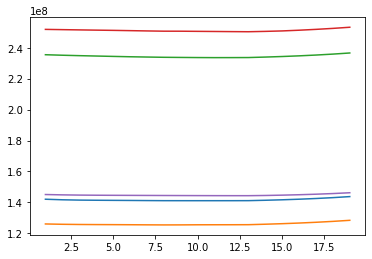

In [30]:
plt.plot(reg_lasso.alphas_, reg_lasso.mse_path_)
reg_lasso.alpha_

In [47]:
#plt.plot(reg_lasso.alphas_, reg_lasso.mse_path_)
#featureID = np.where(reg_lasso.coef_ != 0)
#trainX.columns[featureID], reg_lasso.coef_[featureID]
#reg_lasso.coef_[:20], trainX.columns[:20]

zipped = zip(np.abs(reg_lasso.coef_), trainX.columns)
feature_ranked = [x for _,x in sorted(zipped, reverse=True)]
zipped = zip(np.abs(reg_lasso.coef_), trainX.columns)
coef_ranked = [x for x,_ in sorted(zipped, reverse=True)]

In [54]:

#important_featuresID = [i for i, e in enumerate(trainX.columns) if e in set(feature_ranked)]

for i in range(len(feature_ranked)):
    if coef_ranked[i] != 0:
        id = np.where(trainX.columns==feature_ranked[i])
        print(feature_ranked[i], reg_lasso.coef_[id][0])
#feature_ranked, reg_lasso.coef_[important_featuresID]

ZHVI_prev 90399.24100829565
ZHVI 19754.606186094734
State_CA 2520.8822258763635
CPI -2195.848181870956
Year 1822.6267237622023
State_CO 1037.8295565329447
State_MA 1008.0642366534183
State_OR 937.2126675349679
State_OK -927.6442768398972
UnemploymentRate -806.2673011704298
State_WA 749.8692604271064
State_NJ 680.3674649015514
residt 661.0701034566738
Month -608.3593578863142
inc -567.2915373466249
State_AR -408.01996702140997
State_OH -226.56331458697517
State_KY -153.0666400803535
Interest Rate -119.71056642555557
hospital_rating -65.50473359585666
inc_ineql 48.743225013696915
BD 35.96492986761399
State_VA 30.072272218398926
public_schools_count -19.92666629719066
migr 17.09395841136787


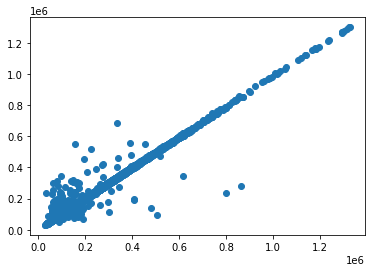

In [332]:
plt.scatter(testY, pred_sq)

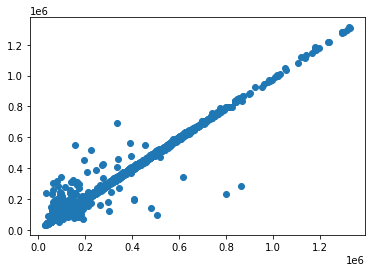

In [331]:
plt.scatter(testY, pred_lasso)